# LSTM Autoencoder for Rare Event Binary Classification

This is a continuation of the regular autoencoder for rare event classification presented in
https://towardsdatascience.com/extreme-rare-event-classification-using-autoencoders-in-keras-a565b386f098
and code present in
https://github.com/cran2367/autoencoder_classifier/blob/master/autoencoder_classifier.ipynb
Here we will show an implementation of building a binary classifier using LSTM Autoencoders. 
Similar to the previous post, the purpose is to show the implementation steps. The Autoencoder tuning for performance improvement can be done.

LSTM requires closer attention to preparing the data. Here we have all the steps, and few tests to validate the data preparation.

The dataset used here is taken from here,

**Dataset: Rare Event Classification in Multivariate Time Series** https://arxiv.org/abs/1809.10717 (please cite this article, if using the dataset).

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from keras import optimizers, Sequential
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

from sklearn.model_selection import train_test_split

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

## Reading and preparing data

The data is taken from https://arxiv.org/abs/1809.10717. Please use this source for any citation.

In [70]:
df = pd.read_csv("data/processminer-rare-event-mts - data.csv") 
df.head(n=5)  # visualize the data.

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127998,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161567,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


### Shift the data

This is a timeseries data in which we have to predict the event (y = 1) ahead in time. In this data, consecutive rows are 2 minutes apart. We will shift the labels in column `y` by 2 rows to do a 4 minute ahead prediction.

In [71]:
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    '''
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s. 
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.
    
    Inputs:
    df       A pandas dataframe with a binary labeled column. 
             This labeled column should be named as 'y'.
    shift_by An integer denoting the number of rows to shift.
    
    Output
    df       A dataframe with the binary labels shifted by shift.
    '''

    vector = df['y'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'y'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [72]:
'''
Shift the data by 2 units, equal to 4 minutes.

Test: Testing whether the shift happened correctly.
'''
print('Before shifting')  # Positive labeled rows before shifting.
one_indexes = df.index[df['y'] == 1]
display(df.iloc[(one_indexes[0]-3):(one_indexes[0]+2), 0:5].head(n=5))

# Shift the response column y by 2 rows to do a 4-min ahead prediction.
df = curve_shift(df, shift_by = -2)

print('After shifting')  # Validating if the shift happened correctly.
display(df.iloc[(one_indexes[0]-4):(one_indexes[0]+1), 0:5].head(n=5))  

Before shifting


,time,y,x1,x2,x3
256,5/1/99 8:32,0,1.016235,-4.058394,-1.097158
257,5/1/99 8:34,0,1.005602,-3.876199,-1.074373
258,5/1/99 8:36,0,0.933933,-3.868467,-1.249954
259,5/1/99 8:38,1,0.892311,-13.332664,-10.006578
260,5/1/99 10:50,0,0.020062,-3.987897,-1.248529


After shifting


,time,y,x1,x2,x3
255,5/1/99 8:30,0.0,0.997107,-3.865720,-1.133779
256,5/1/99 8:32,0.0,1.016235,-4.058394,-1.097158
257,5/1/99 8:34,1.0,1.005602,-3.876199,-1.074373
258,5/1/99 8:36,1.0,0.933933,-3.868467,-1.249954
260,5/1/99 10:50,0.0,0.020062,-3.987897,-1.248529


If we note here, we moved the positive label at 5/1/99 8:38 to t-1 and t-2 timestamps, and dropped row t. There is a time difference of more than 2 minutes between a break row and the next row because in the data consecutive break rows are deleted. This was done to prevent a classification model learn predicting a break after the break has happened. Refer https://arxiv.org/abs/1809.10717 for details.

In [73]:
# Remove time column, and the categorical columns
df = df.drop(['time', 'x28', 'x61'], axis=1)

# Prepare data for LSTM models

LSTM is a bit more demanding than other models. Significant amount of time and attention goes in preparing the data that fits an LSTM.

First, we will create the 3-dimensional arrays of shape: (samples x timesteps x features). Samples mean the number of data points. Timesteps is the number of time steps we look back at any time t to make a prediction. This is also referred to as lookback period. The features is the number of features the data has, in other words, the number of predictors in a multivariate data.

In [74]:
input_X = df.loc[:, df.columns != 'y'].values  # converts the df to a numpy array
input_y = df['y'].values

n_features = input_X.shape[1]  # number of features

In [75]:
def temporalize(X, y, lookback):
    X = []
    y = []
    for i in range(len(input_X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(input_X[[(i+j+1)], :])
        X.append(t)
        y.append(input_y[i+lookback+1])
    return X, y

In LSTM, to make prediction at any time t, we will look at data from (t-lookback):t. In the following, we have an example to show how the input data are transformed with the `temporalize` function with `lookback=5`. For the modeling, we may use a longer lookback.

In [76]:
'''
Test: The 3D tensors (arrays) for LSTM are forming correctly.
'''
print('First instance of y = 1 in the original data')
display(df.iloc[(np.where(np.array(input_y) == 1)[0][0]-5):(np.where(np.array(input_y) == 1)[0][0]+1), ])

lookback = 5  # Equivalent to 10 min of past data.
# Temporalize the data
X, y = temporalize(X = input_X, y = input_y, lookback = lookback)

print('For the same instance of y = 1, we are keeping past 3 samples in the 3D predictor array, X.')
display(pd.DataFrame(np.concatenate(X[np.where(np.array(y) == 1)[0][0]], axis=0 ))) 

First instance of y = 1 in the original data


,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60
252,0.0,0.987078,-4.025989,-1.210205,0.899603,0.450338,14.098854,0.000732,-0.051043,-0.059966,...,29.984624,11.248703,-0.752385,-5.014893,-67.454037,66.232568,4.114269,0.033726,4.845087,0.007776
253,0.0,0.921726,-3.728572,-1.230373,-1.598718,0.227178,14.594612,0.000061,-0.051043,-0.040129,...,29.984624,11.253342,-0.752385,-5.014987,-58.029477,66.310022,3.537487,0.032518,4.969500,0.007760
254,0.0,0.975947,-3.913736,-1.304682,0.561987,0.004034,14.630532,0.000732,-0.051043,-0.040129,...,29.984624,11.257736,-0.752385,-5.015081,-61.783749,71.917352,3.473400,0.031310,2.981432,0.007743
255,0.0,0.997107,-3.865720,-1.133779,0.377295,-0.219126,14.666420,0.000732,-0.061114,-0.040129,...,29.984624,11.262375,-0.752385,-5.015176,-70.151791,73.876977,3.473400,0.030776,2.563593,0.007727
256,0.0,1.016235,-4.058394,-1.097158,2.327307,-0.442286,14.702309,0.000732,-0.061114,-0.040129,...,29.984624,11.267013,-0.752385,-5.015270,-60.884701,72.188928,4.114269,0.031186,2.982454,0.007711
257,1.0,1.005602,-3.876199,-1.074373,0.844397,-0.553050,14.738228,0.000732,-0.061114,-0.030057,...,29.984624,11.271652,-0.752385,-5.015364,-69.553891,70.500879,4.050182,0.031596,3.746714,0.007695


For the same instance of y = 1, we are keeping past 3 samples in the 3D predictor array, X.


,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
0,0.921726,-3.728572,-1.230373,-1.598718,0.227178,14.594612,0.000061,-0.051043,-0.040129,0.001791,...,29.984624,11.253342,-0.752385,-5.014987,-58.029477,66.310022,3.537487,0.032518,4.969500,0.007760
1,0.975947,-3.913736,-1.304682,0.561987,0.004034,14.630532,0.000732,-0.051043,-0.040129,0.001791,...,29.984624,11.257736,-0.752385,-5.015081,-61.783749,71.917352,3.473400,0.031310,2.981432,0.007743
2,0.997107,-3.865720,-1.133779,0.377295,-0.219126,14.666420,0.000732,-0.061114,-0.040129,0.001791,...,29.984624,11.262375,-0.752385,-5.015176,-70.151791,73.876977,3.473400,0.030776,2.563593,0.007727
3,1.016235,-4.058394,-1.097158,2.327307,-0.442286,14.702309,0.000732,-0.061114,-0.040129,0.001791,...,29.984624,11.267013,-0.752385,-5.015270,-60.884701,72.188928,4.114269,0.031186,2.982454,0.007711
4,1.005602,-3.876199,-1.074373,0.844397,-0.553050,14.738228,0.000732,-0.061114,-0.030057,0.001791,...,29.984624,11.271652,-0.752385,-5.015364,-69.553891,70.500879,4.050182,0.031596,3.746714,0.007695


The two tables are the same. This testifies that we are correctly taking 3 samples (= lookback), X(t):X(t-3) to predict y(t).

### Divide the data into train, valid, and test

In [33]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=DATA_SPLIT_PCT, random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In [34]:
X_train.shape


(11691, 5, 1, 59)

#### Reshaping the data
The tensors we have here are 4-dimensional. We will reshape them into the desired 3-dimensions corresponding to sample x lookback x features.

In [35]:
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)

X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)

### Standardize the data
It is usually better to use a standardized data (transformed to Gaussian, mean 0 and sd 1) for autoencoders.

One common mistake is: we normalize the entire data and then split into train-test. This is not correct. Test data should be completely unseen to anything during the modeling. We should normalize the test data using the feature summary statistics computed from the training data. For normalization, these statistics are the mean and variance for each feature. 

The same logic should be used for the validation set. This makes the model more stable for a test data.

To do this, we will require two UDFs.

- `flatten`: This function will re-create the original 2D array from which the 3D arrays were created. This function is the inverse of `temporalize`, meaning `X = flatten(temporalize(X))`.
- `scale`: This function will scale a 3D array that we created as inputs to the LSTM.

In [36]:
def flatten(X):
    '''
    Flatten a 3D array.
    
    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    
    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [37]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_train))

In [ ]:
X_train_scaled = scale(X_train, scaler)

In [38]:
'''
Test: Check if the scaling is correct.

The test succeeds if all the column means 
and variances are 0 and 1, respectively, after
flattening.
'''
a = flatten(X_train_scaled)
print('colwise mean', np.mean(a, axis=0).round(6))
print('colwise variance', np.var(a, axis=0))

colwise mean [ 0. -0.  0.  0.  0. -0.  0.  0.  0.  0.  0. -0. -0. -0. -0.  0. -0. -0.
 -0. -0.  0.  0. -0. -0. -0.  0.  0.  0. -0.  0.  0.  0. -0. -0. -0.  0.
  0.  0. -0. -0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0.  0. -0. -0.  0.
  0. -0. -0.  0.  0.]
colwise variance [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


The test succeeded. Now we will _scale_ the validation and test sets.

In [39]:
X_valid = scale(X_valid, scaler)

X_test = scale(X_test, scaler)

## Autoencoder training

First we will initialize the Autoencoder architecture. We are building a simple autoencoder. More complex architectures and other configurations should be explored.

In [40]:
timesteps =  X_train.shape[1] # equal to the lookback
n_features =  X_train.shape[2] # 59

epochs = 500
batch = 64
lr = 0.0001

In [92]:
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(timesteps, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(1, activation='relu'))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(timesteps, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (None, 5, 5)              1300      
_________________________________________________________________
lstm_39 (LSTM)               (None, 5, 16)             1408      
_________________________________________________________________
lstm_40 (LSTM)               (None, 1)                 72        
_________________________________________________________________
repeat_vector_8 (RepeatVecto (None, 5, 1)              0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 5, 5)              140       
_________________________________________________________________
lstm_42 (LSTM)               (None, 5, 16)             1408      
_________________________________________________________________
time_distributed_8 (TimeDist (None, 5, 59)             1003      
Total para

As a rule-of-thumb, look at the number of parameters. If not using any regularization, keep this less than the number of samples. If using regularization, depending on the degree of regularization you can let more parameters in the model that is greater than the sample size. For example, if using dropout with 0.5, you can have up to double the sample size (loosely speaking).

In [ ]:
adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train, X_train, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_valid, X_valid),
                                                verbose=2).history

Train on 11691 samples, validate on 2923 samples
Epoch 1/500
 - 8s - loss: 0.9955 - val_loss: 1.0305
Epoch 2/500
 - 2s - loss: 0.9949 - val_loss: 1.0282
Epoch 3/500
 - 2s - loss: 0.9709 - val_loss: 0.9869
Epoch 4/500
 - 2s - loss: 0.9382 - val_loss: 0.9601
Epoch 5/500
 - 2s - loss: 0.9099 - val_loss: 0.9326
Epoch 6/500
 - 2s - loss: 0.8843 - val_loss: 0.9105
Epoch 7/500
 - 2s - loss: 0.8660 - val_loss: 0.8963
Epoch 8/500
 - 2s - loss: 0.8535 - val_loss: 0.8858
Epoch 9/500
 - 2s - loss: 0.8439 - val_loss: 0.8773
Epoch 10/500
 - 2s - loss: 0.8356 - val_loss: 0.8692
Epoch 11/500
 - 2s - loss: 0.8268 - val_loss: 0.8599
Epoch 12/500
 - 2s - loss: 0.8164 - val_loss: 0.8490
Epoch 13/500
 - 2s - loss: 0.8059 - val_loss: 0.8396
Epoch 14/500
 - 2s - loss: 0.7974 - val_loss: 0.8318
Epoch 15/500
 - 2s - loss: 0.7903 - val_loss: 0.8254
Epoch 16/500
 - 2s - loss: 0.7847 - val_loss: 0.8202
Epoch 17/500
 - 2s - loss: 0.7799 - val_loss: 0.8157
Epoch 18/500
 - 2s - loss: 0.7756 - val_loss: 0.8116
Epoch 

Epoch 154/500
 - 2s - loss: 0.4796 - val_loss: 0.4855
Epoch 155/500
 - 2s - loss: 0.4792 - val_loss: 0.4850
Epoch 156/500
 - 2s - loss: 0.4786 - val_loss: 0.4842
Epoch 157/500
 - 2s - loss: 0.4783 - val_loss: 0.4839
Epoch 158/500
 - 2s - loss: 0.4778 - val_loss: 0.4834
Epoch 159/500
 - 2s - loss: 0.4773 - val_loss: 0.4825
Epoch 160/500
 - 2s - loss: 0.4770 - val_loss: 0.4830
Epoch 161/500
 - 2s - loss: 0.4760 - val_loss: 0.4832
Epoch 162/500
 - 2s - loss: 0.4758 - val_loss: 0.4812
Epoch 163/500
 - 2s - loss: 0.4755 - val_loss: 0.4814
Epoch 164/500
 - 2s - loss: 0.4749 - val_loss: 0.4809
Epoch 165/500
 - 2s - loss: 0.4750 - val_loss: 0.4806
Epoch 166/500
 - 2s - loss: 0.4741 - val_loss: 0.4827
Epoch 167/500
 - 2s - loss: 0.4735 - val_loss: 0.4797
Epoch 168/500
 - 2s - loss: 0.4732 - val_loss: 0.4794
Epoch 169/500
 - 2s - loss: 0.4730 - val_loss: 0.4805
Epoch 170/500
 - 2s - loss: 0.4727 - val_loss: 0.4790
Epoch 171/500
 - 2s - loss: 0.4722 - val_loss: 0.4783
Epoch 172/500
 - 2s - loss: 

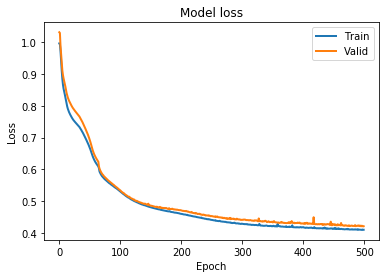

In [102]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

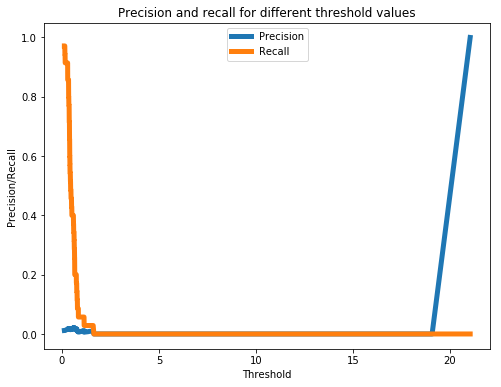

In [82]:
valid_x_predictions = lstm_autoencoder.predict(X_valid)
mse = np.mean(np.power(flatten(X_valid) - flatten(valid_x_predictions), 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_valid.tolist()})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [103]:
test_x_predictions = lstm_autoencoder.predict(X_test)
mse = np.mean(np.power(flatten(X_test) - flatten(test_x_predictions), 2), axis=1)

In [ ]:
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test.tolist()})

In [ ]:
threshold_fixed = 0.7
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [ ]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]

In [ ]:
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

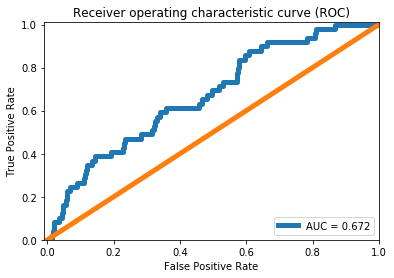

In [105]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()